In [103]:
#Import necessary packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

%matplotlib inline

#Read in the data-set
df = pd.read_csv('./crime_in_atl_YTD2017.csv')
df.head()

,MI_PRINX,offense_id,rpt_date,occur_date,occur_time,poss_date,poss_time,beat,apt_office_prefix,apt_office_num,...,dispo_code,MaxOfnum_victims,Shift,Avg Day,loc_type,UC2 Literal,neighborhood,npu,x,y
0,8924155,173650072,12/31/2017,12/30/2017,23:15:00,12/31/2017,00:30:00,510,NaN,NaN,...,NaN,2.0,Morn,Sat,13.0,LARCENY-FROM VEHICLE,Downtown,M,-84.38013,33.75582
1,8924156,173650102,12/31/2017,12/18/2017,13:00:00,12/30/2017,22:00:00,501,NaN,NaN,...,NaN,1.0,Unk,Unk,13.0,LARCENY-FROM VEHICLE,Home Park,E,-84.39745,33.78674
2,8924157,173650144,12/31/2017,12/30/2017,22:01:00,12/31/2017,01:00:00,303,NaN,NaN,...,NaN,1.0,Morn,Sat,18.0,LARCENY-FROM VEHICLE,Mechanicsville,V,-84.39486,33.73760
3,8924158,173650149,12/31/2017,12/30/2017,20:00:00,12/31/2017,01:06:00,507,NaN,NaN,...,NaN,1.0,Eve,Sat,18.0,LARCENY-FROM VEHICLE,Castleberry Hill,M,-84.39887,33.75156
4,8924159,173650159,12/31/2017,12/31/2017,00:41:00,12/31/2017,00:48:00,409,NaN,NaN,...,NaN,2.0,Morn,Sun,18.0,LARCENY-FROM VEHICLE,Adams Park,R,-84.46522,33.72146


In [104]:
df.columns

Index(['MI_PRINX', 'offense_id', 'rpt_date', 'occur_date', 'occur_time',
       'poss_date', 'poss_time', 'beat', 'apt_office_prefix', 'apt_office_num',
       'location', 'MinOfucr', 'MinOfibr_code', 'dispo_code',
       'MaxOfnum_victims', 'Shift', 'Avg Day', 'loc_type', 'UC2 Literal',
       'neighborhood', 'npu', 'x', 'y'],
      dtype='object')

In [105]:
#Derive a list of columns with more than 80% missing values
(np.sum(df.notnull())/df.shape[0] < 0.80)==True

MI_PRINX             False
offense_id           False
rpt_date             False
occur_date           False
occur_time           False
poss_date            False
poss_time            False
beat                 False
apt_office_prefix     True
apt_office_num        True
location             False
MinOfucr             False
MinOfibr_code        False
dispo_code            True
MaxOfnum_victims     False
Shift                False
Avg Day              False
loc_type             False
UC2 Literal          False
neighborhood         False
npu                  False
x                    False
y                    False
dtype: bool

In [106]:
#Drop columns with more than 80% missing values
df.drop(['apt_office_num','apt_office_prefix','dispo_code'],inplace=True,axis=1)

In [107]:
#Fix column names with white spaces
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [108]:
#Check unique values in each columns
print ("Columns and unique values")
print ("-----------------------")
for i in df.columns:
    col=getattr(df,i).nunique()
    print(i , '-->' , col)

Columns and unique values
-----------------------
MI_PRINX --> 26759
offense_id --> 26759
rpt_date --> 365
occur_date --> 471
occur_time --> 1354
poss_date --> 412
poss_time --> 1433
beat --> 86
location --> 13865
MinOfucr --> 51
MinOfibr_code --> 67
MaxOfnum_victims --> 21
Shift --> 4
Avg_Day --> 8
loc_type --> 32
UC2_Literal --> 11
neighborhood --> 238
npu --> 25
x --> 9183
y --> 9016


In [109]:
#Check null values in each columns
print ("Columns and null value counts")
print ("-----------------------")
for i in df.columns:
    null_count = np.sum(getattr(df,i).isnull())
    print(i , '-->' , null_count)

Columns and null value counts
-----------------------
MI_PRINX --> 0
offense_id --> 0
rpt_date --> 0
occur_date --> 0
occur_time --> 11
poss_date --> 0
poss_time --> 4
beat --> 0
location --> 0
MinOfucr --> 0
MinOfibr_code --> 1
MaxOfnum_victims --> 75
Shift --> 0
Avg_Day --> 0
loc_type --> 3344
UC2_Literal --> 0
neighborhood --> 1185
npu --> 260
x --> 0
y --> 0


In [110]:
#Create a new dataframe with only columns relevant for analysis
df_crime= df[['occur_date','occur_time','UC2_Literal','x','y']]

In [111]:
#To eliminate warning from chained_assignment
pd.options.mode.chained_assignment = None 

In [112]:
def derive_occur_time_hour(df_crime):
    '''
    This function returns df_crime dataframe after deriving occur_time_hour from occur_time column of the dataframe, imputes missing values and drops original column
    '''
    df_crime['occur_time_hour']=df_crime['occur_time'].str.slice(0,2)
    #Impute missing values for 11 rows
    imp=Imputer(missing_values="NaN", strategy="most_frequent" )
    df_crime["occur_time_hour"]=imp.fit_transform(df_crime[["occur_time_hour"]])
    #drop the orignal column
    df_crime.drop(['occur_time'],inplace=True,axis=1)
    return df_crime

df_crime = derive_occur_time_hour(df_crime)

In [113]:
def derive_year_month_day(df_crime):
    '''
    This function returns df_crime dataframe after deriving occur_date_year, occur_date_month, occur_date_day from occur_date column of the dataframe
    '''
    df_crime['occur_date_year']=df_crime['occur_date'].str[-4:]
    df_crime['occur_date_month']=df_crime['occur_date'].str[0:2]
    df_crime['occur_date_day']=df_crime['occur_date'].str[0:5].str[-2:]
    return df_crime
df_crime = derive_year_month_day(df_crime)

In [114]:
def derive_occur_shift(df_crime):
    '''
    This function returns occur_shift derived from occur_time_hour column of the dataframe
    '''
    if (df_crime['occur_time_hour'] >= 21 or df_crime['occur_time_hour'] < 5):
        return 'Night'
    elif (df_crime['occur_time_hour'] >= 5 and df_crime['occur_time_hour'] < 12):
        return 'Morning'
    elif (df_crime['occur_time_hour'] >= 12 and df_crime['occur_time_hour'] < 17):
        return 'Afternoon'
    elif (df_crime['occur_time_hour'] >= 17 and df_crime['occur_time_hour'] < 21):
        return 'Evening'
    else:
        return np.nan

df_crime['occur_shift'] = df_crime.apply(occur_shift, axis = 1)

In [115]:
def derive_occur_dayofweek(df_crime):
    '''
    This function returns df_crime dataframe after deriving occur_dayOfweek from occur_date column of the dataframe
    '''
    df_crime['occur_date']= df_crime[['occur_date']].apply(pd.to_datetime)
    dayOfweek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    df_crime['occur_dayOfweek']=df_crime['occur_date'].dt.dayofweek.map(dayOfweek)
    return df_crime
df_crime = derive_occur_dayofweek(df_crime)

In [116]:
#Rename columns
df_crime.rename(columns = {'UC2_Literal':'crime_type', 'x':'longitude', 'y':'latitude'}, inplace = True) 
df_crime

,occur_date,crime_type,longitude,latitude,occur_time_hour,occur_date_year,occur_date_month,occur_date_day,occur_shift,occur_dayOfweek
0,2017-12-30,LARCENY-FROM VEHICLE,-84.38013,33.75582,23.0,2017,12,30,Night,Saturday
1,2017-12-18,LARCENY-FROM VEHICLE,-84.39745,33.78674,13.0,2017,12,18,Afternoon,Monday
2,2017-12-30,LARCENY-FROM VEHICLE,-84.39486,33.73760,22.0,2017,12,30,Night,Saturday
3,2017-12-30,LARCENY-FROM VEHICLE,-84.39887,33.75156,20.0,2017,12,30,Evening,Saturday
4,2017-12-31,LARCENY-FROM VEHICLE,-84.46522,33.72146,0.0,2017,12,31,Night,Sunday
5,2017-12-30,LARCENY-FROM VEHICLE,-84.34660,33.74006,23.0,2017,12,30,Night,Saturday
6,2017-12-31,ROBBERY-PEDESTRIAN,-84.37373,33.74505,1.0,2017,12,31,Night,Sunday
7,2017-12-31,LARCENY-FROM VEHICLE,-84.37190,33.77303,0.0,2017,12,31,Night,Sunday
8,2017-12-30,LARCENY-FROM VEHICLE,-84.37285,33.74639,0.0,2017,12,30,Night,Saturday
9,2017-12-31,BURGLARY-RESIDENCE,-84.38625,33.72579,0.0,2017,12,31,Night,Sunday


In [117]:
#Convert data types for columns
df_crime['longitude'] = df_crime['longitude'].astype(float)
df_crime['latitude'] = df_crime['latitude'].astype(float)
df_crime['occur_date_year'] = df_crime['occur_date_year'].astype(int)
df_crime['occur_date_month'] = df_crime['occur_date_month'].astype(int)
df_crime['occur_date_day'] = df_crime['occur_date_day'].astype(int)
df_crime.dtypes

occur_date          datetime64[ns]
crime_type                  object
longitude                  float64
latitude                   float64
occur_time_hour            float64
occur_date_year              int64
occur_date_month             int64
occur_date_day               int64
occur_shift                 object
occur_dayOfweek             object
dtype: object

Text(0,0.5,'Type of Crime')

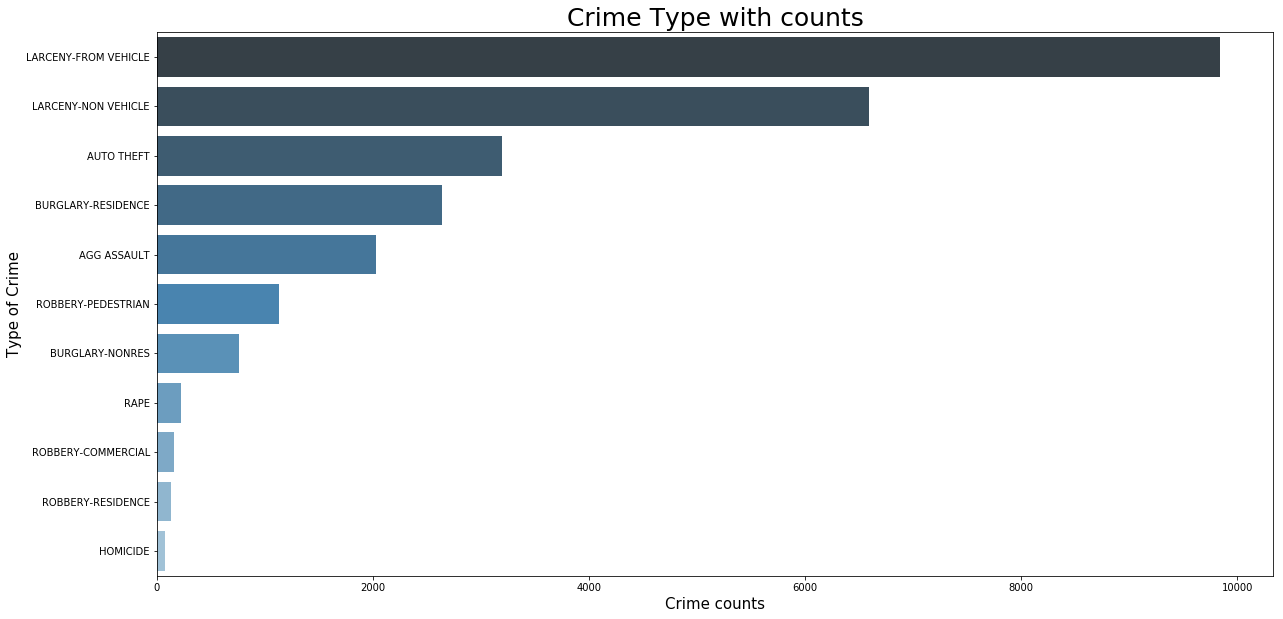

In [118]:
#Plot seaborn count plot with type of crimes
sns.set_style ({'figure.figsize': '20.0, 10.0'}, )
ax=sns.countplot(y="crime_type", data=df_crime, order=df_crime.crime_type.value_counts().index,palette=("Blues_d"))
ax.set_title('Crime Type with counts',fontsize=25)
ax.set_xlabel('Crime counts',fontsize=15)
ax.set_ylabel('Type of Crime',fontsize=15)

[Text(0,0.5,'Count'),
 Text(0.5,0,'Hour of the Day'),
 Text(0.5,1,'Crime count by Hour of day')]

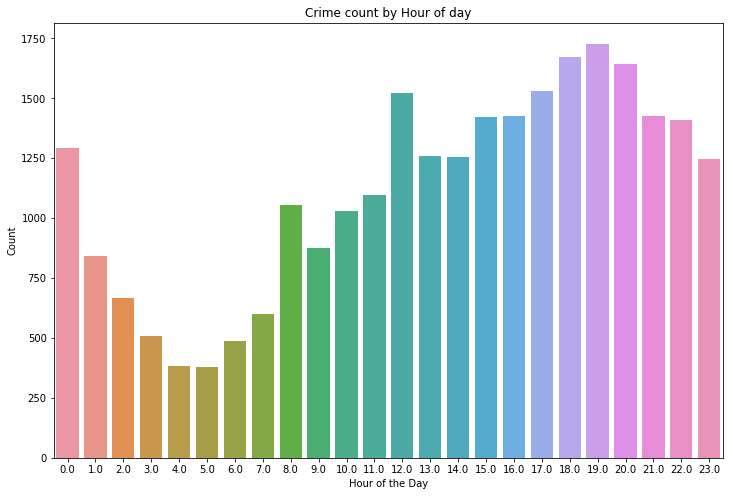

In [119]:
#Plot seaborn bar plot with crime counts by hour of the day
plt.figure(figsize=(12,8))
ax = sns.barplot(df_crime.occur_time_hour.value_counts().index, df_crime.occur_time_hour.value_counts())
ax.set(xlabel="Hour of the Day", ylabel='Count', title = "Crime count by Hour of day")

[Text(0,0.5,'Count'),
 Text(0.5,0,'Occur Day of Week'),
 Text(0.5,1,'Crime count by day of Week')]

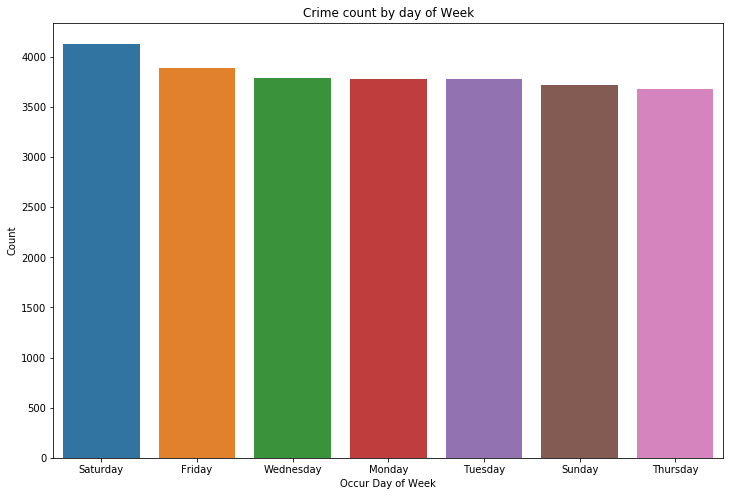

In [120]:
#Plot seaborn bar plot with crime counts by day of the week
plt.figure(figsize=(12,8))
ax = sns.barplot(df_crime.occur_dayOfweek.value_counts().index, df_crime.occur_dayOfweek.value_counts())
ax.set(xlabel="Occur Day of Week", ylabel='Count', title = "Crime count by day of Week")

[Text(0,0.5,'Count'),
 Text(0.5,0,'Occur Day'),
 Text(0.5,1,'Crime count by each day of Month')]

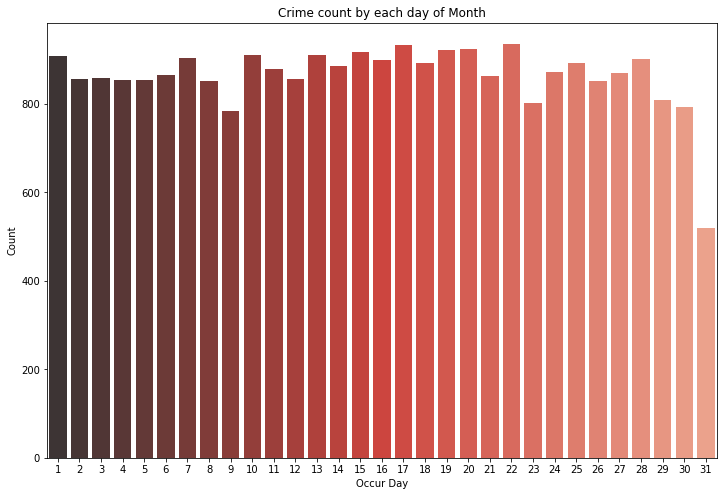

In [121]:
#Plot seaborn bar plot with crime counts by each day of the month
plt.figure(figsize=(12,8))
ax = sns.barplot(df_crime.occur_date_day.value_counts().index, df_crime.occur_date_day.value_counts(),palette=("Reds_d"))
ax.set(xlabel="Occur Day", ylabel='Count', title = "Crime count by each day of Month")

Text(0,0.5,'Type of Crime')

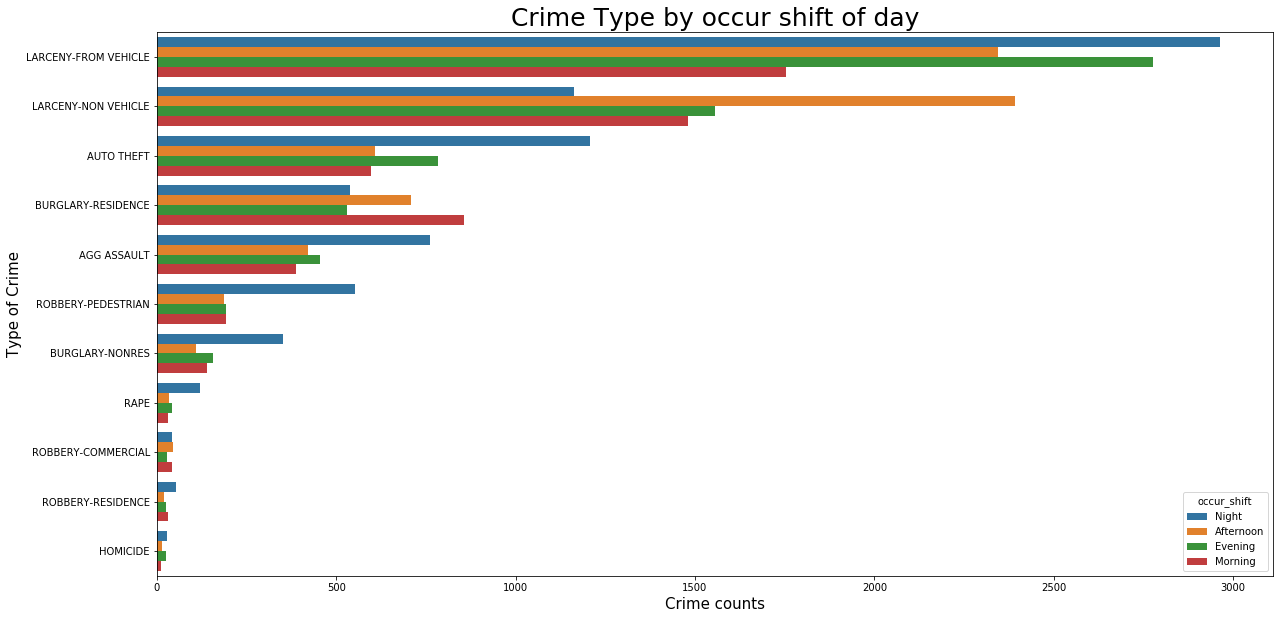

In [122]:
#Plot seaborn count plot with crime types with respect to occur shift of day
sns.set_style ({'figure.figsize': '20.0, 10.0'}, )
ax = sns.countplot(y='crime_type', data=df_crime, hue=df_crime['occur_shift'],order=df_crime.crime_type.value_counts().index)
ax.set_title('Crime Type by occur shift of day',fontsize=25)
ax.set_xlabel('Crime counts',fontsize=15)
ax.set_ylabel('Type of Crime',fontsize=15)

In [123]:
def generateBaseMap(default_location=[33.740000, -84.380000], default_zoom_start=9):
    '''
    This function returns a base map for Atlanta area with zooming capability
    '''
    base_map = folium.Map(location=default_location,control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map=generateBaseMap()

In [124]:
#Plot heatmap using longitude and latitude on basemap
HeatMap(data=df_crime[['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(),radius=8).add_to(base_map)
base_map

In [125]:
#Derive list of lists for logitudes and latitude with respect to months
df_occur_date_month_list = []
for month in df_crime.occur_date_month.sort_values().unique():
    df_occur_date_month_list.append(df_crime.loc[df_crime.occur_date_month == month, ['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())


In [126]:
#Plot heatmap using longitude and latitude on basemap with respect to months
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_occur_date_month_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

In [127]:
#Derive list of lists for logitudes and latitude with respect to hour
df_occur_time_hour_list = []
for hour in df_crime.occur_time_hour.sort_values().unique():
    df_occur_time_hour_list.append(df_crime.loc[df_crime.occur_time_hour == hour, ['latitude', 'longitude']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist())


In [128]:
#Plot heatmap using longitude and latitude on basemap with respect to hour
base_map = generateBaseMap(default_zoom_start=11)
HeatMapWithTime(df_occur_time_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map